# GOING DEEPER 02 : Augmentation

## 준비한 데이터
+ Stanford Dogs 데이터셋
## 텐서플로 Random Augmentation 함수 목록
+ random_brightness()
+ random_contrast()
+ random_crop()
+ random_flip_left_right()
+ random_flip_up_down()
+ random_hue()
+ random_jpeg_quality()
+ random_saturation()
# 0. 라이브러리 import 및 데이터셋 준비

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

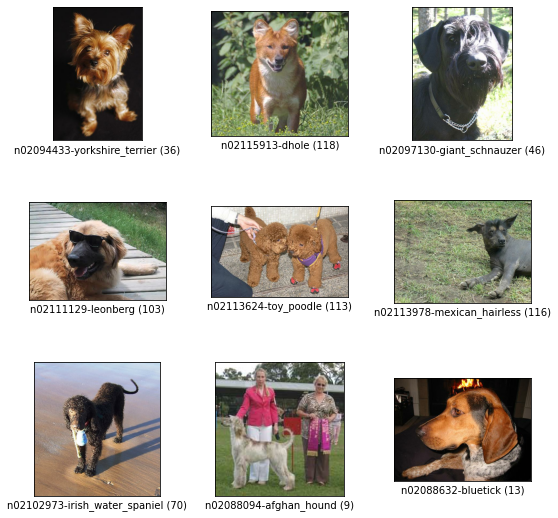

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

# 1. 데이터셋 전처리 함수 정의

In [ ]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# CutMix
이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 방법으로
배치 내의 이미지를 두 개 골라 바운딩 박스의 위치를 랜덤하게 뽑고
해당 영역을 잘라내서 두 개의 이미지를 섞어준다.
섞인 이미지의 전체 이미지 대비 비율을 계산하고
면적에 비례해서 두 라벨을 섞어준다.

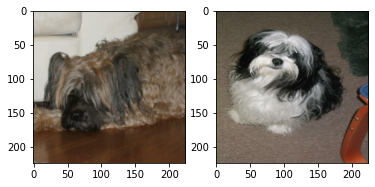

In [ ]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [ ]:
# 바탕 이미지 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+height//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(44, shape=(), dtype=int32) tf.Tensor(147, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


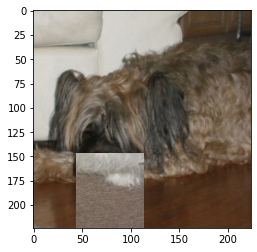

In [ ]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [ ]:
# 섞인 이미지의 면적에 비례해서 라벨을 섞어주는 함수
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10742188,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
# 위에서 구현한 두 함수를 활용하여 배치 단위의 cutmix() 함수 구현
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup
두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로
두 이미지를 섞을 비율을 일정한 범위 내에서 랜덤하게 뽑고
해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.2863983 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.7136017 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

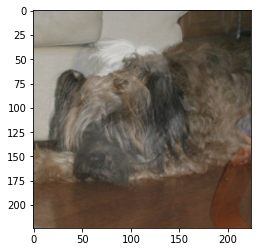

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 2. 데이터셋에 적용하기

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
# 배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 3. 모델 만들기

In [ ]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [ ]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 4. 모델 훈련하기
cutmix(), mixup()을 구현하면서
label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고
One-Hot 벡터 형태로 변환되었기 때문에
sparse_categorical_crossentropy 대신 categorical_crossentropy를 사용해야 한다.

In [ ]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 107s 127ms/step - loss: 2.2165 - accuracy: 0.4421 - val_loss: 3.8283 - val_accuracy: 0.1518
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 0.7933 - accuracy: 0.7782 - val_loss: 1.0705 - val_accuracy: 0.6838
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2686 - accuracy: 0.9388 - val_loss: 0.9576 - val_accuracy: 0.7160
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0668 - accuracy: 0.9942 - val_loss: 0.8881 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0227 - accuracy: 0.9991 - val_loss: 0.8999 - val_accuracy: 0.7436
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0132 - accuracy: 0.9998 - val_loss: 0.9158 - val_accuracy: 0.7436
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0100 - accuracy: 0.9999 - val_loss: 0.9342 - val_a

In [ ]:
df_resnet50_no_aug = pd.DataFrame({
    'val_loss': history_resnet50_no_aug.history['val_loss'],
    'val_accuracy': history_resnet50_no_aug.history['val_accuracy']
    })
df_resnet50_no_aug.to_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_no_aug.csv', index=False)

In [ ]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 126ms/step - loss: 2.2383 - accuracy: 0.4358 - val_loss: 2.9716 - val_accuracy: 0.2627
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.8724 - accuracy: 0.7552 - val_loss: 1.1323 - val_accuracy: 0.6708
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.5146 - accuracy: 0.8587 - val_loss: 1.0923 - val_accuracy: 0.6839
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2754 - accuracy: 0.9316 - val_loss: 0.9914 - val_accuracy: 0.7196
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1270 - accuracy: 0.9764 - val_loss: 0.9821 - val_accuracy: 0.7229
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1036 - accuracy: 0.9820 - val_loss: 0.9415 - val_accuracy: 0.7341
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0483 - accuracy: 0.9935 - val_loss: 1.0168 - val_a

In [ ]:
df_resnet50_aug = pd.DataFrame({
    'val_loss': history_resnet50_aug.history['val_loss'],
    'val_accuracy': history_resnet50_aug.history['val_accuracy']
    })
df_resnet50_aug.to_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_aug.csv', index=False)

In [ ]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 121ms/step - loss: 3.8079 - accuracy: 0.2176 - val_loss: 3.2693 - val_accuracy: 0.2364
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 2.9241 - accuracy: 0.4406 - val_loss: 1.3665 - val_accuracy: 0.6247
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.6024 - accuracy: 0.5399 - val_loss: 1.3241 - val_accuracy: 0.6437
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 2.3680 - accuracy: 0.6139 - val_loss: 1.3011 - val_accuracy: 0.6377
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2442 - accuracy: 0.6598 - val_loss: 1.0996 - val_accuracy: 0.6971
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1393 - accuracy: 0.6912 - val_loss: 1.2763 - val_accuracy: 0.6551
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 1.9954 - accuracy: 0.7347 - val_loss: 1.1130 - val_a

In [ ]:
df_resnet50_cutmix = pd.DataFrame({
    'val_loss': history_resnet50_cutmix.history['val_loss'],
    'val_accuracy': history_resnet50_cutmix.history['val_accuracy']
    })
df_resnet50_cutmix.to_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_cutmix.csv', index=False)

In [ ]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 122ms/step - loss: 3.7355 - accuracy: 0.2386 - val_loss: 4.6634 - val_accuracy: 0.0624
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 2.8492 - accuracy: 0.4805 - val_loss: 1.6405 - val_accuracy: 0.5469
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 2.5823 - accuracy: 0.5856 - val_loss: 1.2864 - val_accuracy: 0.6417
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.3686 - accuracy: 0.6659 - val_loss: 1.3669 - val_accuracy: 0.6200
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2564 - accuracy: 0.7072 - val_loss: 1.5708 - val_accuracy: 0.5800
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1385 - accuracy: 0.7489 - val_loss: 1.2629 - val_accuracy: 0.6573
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.0368 - accuracy: 0.7805 - val_loss: 1.2317 - val_a

In [ ]:
df_resnet50_mixup = pd.DataFrame({
    'val_loss': history_resnet50_mixup.history['val_loss'],
    'val_accuracy': history_resnet50_mixup.history['val_accuracy']
    })
df_resnet50_mixup.to_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_mixup.csv', index=False)

In [ ]:
history_resnet50_no_aug = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_no_aug.csv')
history_resnet50_aug = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_aug.csv')
history_resnet50_cutmix = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_cutmix.csv')
history_resnet50_mixup = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD4/history_resnet50_mixup.csv')

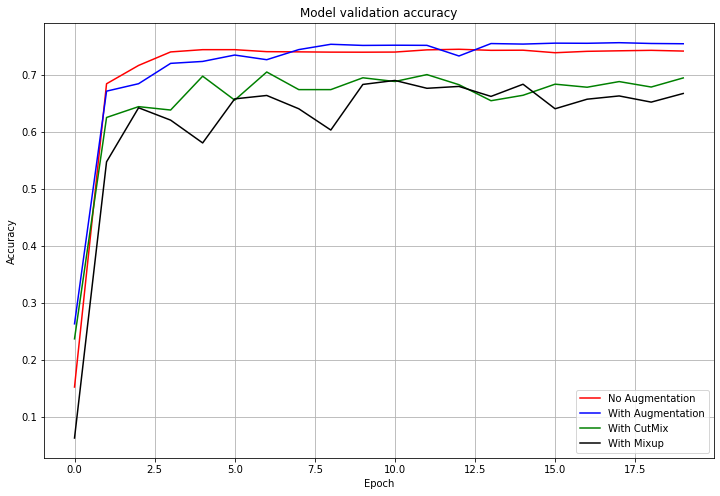

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

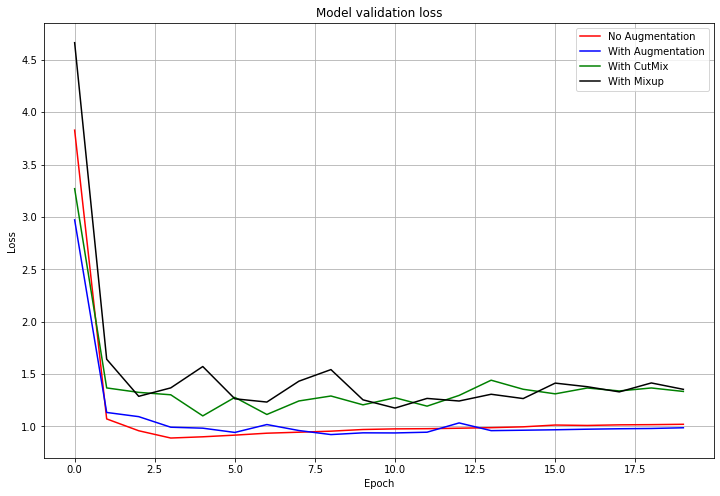

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'b')
plt.plot(history_resnet50_cutmix['val_loss'], 'g')
plt.plot(history_resnet50_mixup['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
acc_data = {'No Augmentation': history_resnet50_no_aug['val_accuracy'], 
            'With Augmentation': history_resnet50_aug['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix['val_accuracy'], 
            'With Mixup': history_resnet50_mixup['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.151819,0.262710,0.236357,0.062383
1,0.683769,0.670826,0.624650,0.546875
2,0.715952,0.683885,0.643657,0.641674
3,0.739622,0.719566,0.637710,0.619986
4,0.743587,0.722948,0.697062,0.579991
5,0.743587,0.734142,0.655084,0.657299
6,0.740089,0.725980,0.704408,0.663246
7,0.739739,0.743703,0.673507,0.639925
8,0.739272,0.753032,0.673507,0.602612
9,0.739156,0.751049,0.694263,0.682603


In [ ]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.707632,0.714232,0.652402,0.618155
std,0.131555,0.108942,0.100323,0.135733
min,0.151819,0.262710,0.236357,0.062383
25%,0.739243,0.725222,0.654822,0.634941
50%,0.740380,0.751108,0.677880,0.657008
75%,0.742479,0.754052,0.689307,0.669018
max,0.744286,0.755830,0.704408,0.689599


# 회고

+ No augmentation 과 With augmentation 부터 비교해보면 With augmentation의 평균이 대략 0.7% 정도 높다 하지만 큰 차이 값은 아니라고 생각한다.
+ 논문에서는 Mixup 과 Cutmix 모두 상승했지만 자료에서는 오히려 떨어져서 이유를 생각해 보았다
+ # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
  위의 코드는 Kaggle에서 가져온 코드이고 random함을 조절해야는 코드이다.

  # get width, height of box
       width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
        height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)



![i](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-2.max-800x600.png)